In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from gerrychain import Graph, GeographicPartition, Election, MarkovChain, constraints
from gerrychain.constraints import single_flip_contiguous 
from gerrychain.proposals import propose_random_flip, recom
from gerrychain.accept import always_accept
from gerrychain.updaters import Tally, cut_edges
from functools import partial
import os

In [2]:
processed_folder = os.path.join(os.getcwd(), "..", "shapefiles", "processed")

NC_graph_path = os.path.join(processed_folder, "north carolina", "precinct_level_w_election.shp")
NC_graph = Graph.from_file(NC_graph_path, ignore_errors=True)

/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)
/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column R_VOTES!
  warnings.warn("NA values found in column {}!".format(column))
/home/mark/.local/lib/python3.9/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column D_VOTES!
  warnings.warn("NA values found in column {}!".format(column))


In [3]:
election = Election("SEN", {"Democratic": "D_VOTES", "Republican": "R_VOTES"})

In [4]:
initial_partition = GeographicPartition(
    NC_graph,
    assignment="CD",
    updaters={
        "population": Tally("TOTPOP", alias="population"),
        "cut_edges": cut_edges,
        "SEN": election
    }
)

<AxesSubplot: >

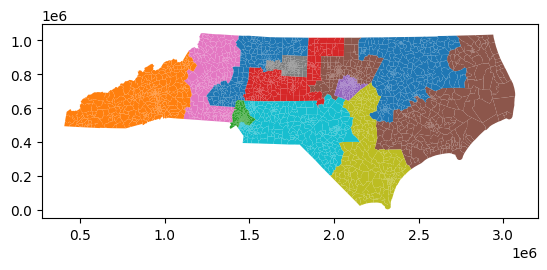

In [5]:
initial_partition.plot()

In [6]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

proposal = partial(
    recom,
    pop_col="TOTPOP",
    pop_target = ideal_population,
    epsilon=0.02,
    node_repeats=2
)

In [7]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [8]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=100
)

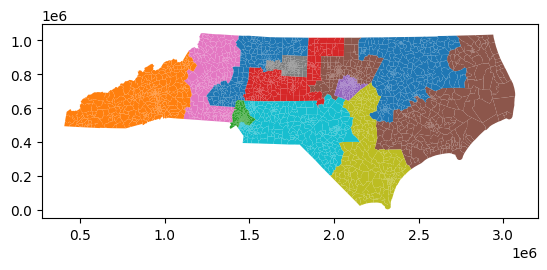

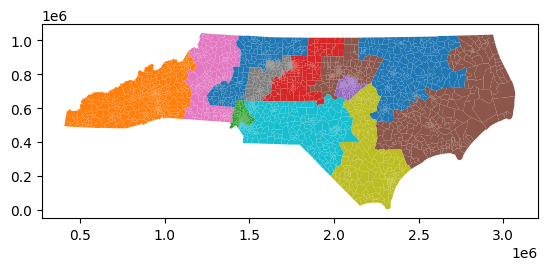

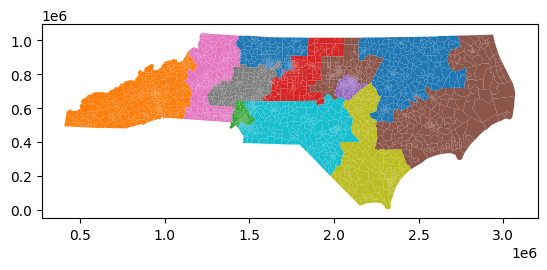

In [9]:
i = 0
for p in chain:
    if i == 3:
        break
        
    p.plot()
    
    i += 1
    